# Detecting Financial Fraud at Scale with Decision Trees and MLflow on Databricks
Following the demonstration provided in Chapter 5 of "The Big Book of Machine Learning Use Cases"

## version 1.0

Created by Parker Dunn  
Created on 12 Oct 2022  
Finished on 20 Oct 2022 (mostly finished on first go, but wanted to put some final touches on the notebook)

In [0]:
%sql
/*  DON'T NEED THIS BECAUSE I ALREADY CREATED A TABLE FROM S3

COPY INTO <database-name>.<table-name>
FROM 's3://bucket-name/path/to/folder'
FILEFORMAT = CSV
COPY_OPTIONS ('mergeSchema' = 'true')
*/

--------------------------------------------------------------------------- 
 ParseException Traceback (most recent call last)
 <command-209380953880284> in <module> 
 5 display ( df ) 
 6 return df
 ----> 7 _sqldf = ____databricks_percent_sql ( ) 
 8 finally : 
 9 del ____databricks_percent_sql

 <command-209380953880284> in ____databricks_percent_sql () 
 2 def ____databricks_percent_sql ( ) : 
 3 import base64
 ----> 4 df = spark . sql ( base64 . standard_b64decode ( "LyoKQ09QWSBJTlRPIDxkYXRhYmFzZS1uYW1lPi48dGFibGUtbmFtZT4KRlJPTSAnczM6Ly9idWNrZXQtbmFtZS9wYXRoL3RvL2ZvbGRlcicKRklMRUZPUk1BVCA9IENTVgpDT1BZX09QVElPTlMgKCdtZXJnZVNjaGVtYScgPSAndHJ1ZScpCiov" ) . decode ( ) ) 
 5 display ( df ) 
 6 return df

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 775 [ Row ( f1 = 1 , f2 = 'row1' ) , Row ( f1 = 2 , f2 = 'row2' ) , Row ( f1 = 3 , f2 = 'row3' ) ] 
 776 """
 --> 777 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 778 
 779 def table ( self , tableName ) : 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 ParseException : 
mismatched input '<EOF>' expecting {'(', 'APPLY', 'CONVERT', 'COPY', 'OPTIMIZE', 'RESTORE', 'ADD', 'ALTER', 'ANALYZE', 'CACHE', 'CLEAR', 'COMMENT', 'COMMIT', 'CREATE', 'DELETE', 'DESC', 'DESCRIBE', 'DFS', 'DROP', 'EXPLAIN', 'EXPORT', 'FROM', 'GRANT', 'IMPORT', 'INSERT', 'LIST', 'LOAD', 'LOCK', 'MAP', 'MERGE', 'MSCK', 'REDUCE', 'REFRESH', 'REPLACE', 'RESET', 'REVOKE', 'ROLLBACK', 'SELECT', 'SET', 'SHOW', 'START', 'SYNC', 'TABLE', 'TRUNCATE', 'UNCACHE', 'UNLOCK', 'UPDATE', 'USE', 'VALUES', 'WITH'}(line 6, pos 2)

== SQL ==
/*
COPY INTO <database-name>.<table-name>
FROM 's3://bucket-name/path/to/folder'
FILEFORMAT = CSV
COPY_OPTIONS ('mergeSchema' = 'true')
*/
--^^^

## Introduction

### Background

The task of detecting financial fraud has historically been done by a subject matter expert creating a set of rules to identify fraudulent behavior. This approach is brittle. A person must update the rules and track the changes in fraud activities constantly to keep the rules updated.


There is a lot of historical data to learn from, but the fraudlent records are a small piece of the overall dataset. This compounds the challenge for a subject matter expert by providing lots of irrelevant information with a small amount of informative data. It is also a challenging environment for machine learning. Equal demonstrations of positive and negative class records (i.e., fraudulent and non-fraudulent records) are the optimal conditions for classification.

### Goal

Develop a machine learning pipeline that performs the same task as the rule-based detection approach implemented by a subject matter expert.

Additionally, not a focus of the tutorial, we will explore monitoring the performance the ML output data to develop a model that can account for changes of fraudulent habits over time.

## EDA

### Showing tables loaded to the compute cluster

In [0]:
%sql
SHOW TABLES
/* You can do this in Spark/PySpark too. I kind of did this below. */

database,tableName,isTemporary
default,ps_20174392719_1491204439457_log,false


In [0]:
df = spark.table("hive_metastore.default.ps_20174392719_1491204439457_log")

In [0]:
display(df)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
225,TRANSFER,1492768.29,C9217739,0.0,0.0,C782140309,5234513.3,6727281.6,0,0
225,TRANSFER,458697.52,C1933499569,0.0,0.0,C1484201631,1296496.33,1755193.85,0,0
225,TRANSFER,811312.89,C580530020,0.0,0.0,C764333244,5766760.5,6578073.39,0,0
225,TRANSFER,731323.95,C235727907,0.0,0.0,C135126939,776486.37,1507810.33,0,0
225,TRANSFER,388165.93,C1800645079,0.0,0.0,C1645396792,513758.97,901924.9,0,0
225,TRANSFER,958472.67,C1854749528,0.0,0.0,C1897130471,2172323.62,3130796.29,0,0
225,TRANSFER,1275484.43,C488622306,0.0,0.0,C925835638,2577270.01,3852754.44,0,0
225,TRANSFER,1022114.42,C1947943574,0.0,0.0,C681553481,1.123534844E7,1.225746285E7,0,0
225,TRANSFER,257629.12,C40915155,0.0,0.0,C591574895,447357.55,704986.66,0,0
225,TRANSFER,135302.65,C94432318,0.0,0.0,C1891097835,262448.48,397751.13,0,0


### Types of Transactions

In [0]:
%sql
SELECT type, count(*)
FROM hive_metastore.default.ps_20174392719_1491204439457_log
GROUP BY type
/* Created the visualization below usig the "+", which allows automatic creation of visualizations rather than having to code it. */

type,count(1)
TRANSFER,532909
CASH_IN,1399284
CASH_OUT,2237500
PAYMENT,2151495
DEBIT,41432


Output can only be rendered in Databricks

In [0]:
%sql
SELECT type, sum(amount)
FROM hive_metastore.default.ps_20174392719_1491204439457_log
GROUP BY type

type,sum(amount)
TRANSFER,4.8529198726316974E11
CASH_IN,2.363673919124592E11
CASH_OUT,3.944129952244929E11
PAYMENT,2.8093371138370094E10
DEBIT,2.2719922127999976E8


Output can only be rendered in Databricks

### Rule-based Model

In this section, I am replicating a faud detection system using rules.  
(This may already be implemented for the version of the dataset that we are using - see 'isFraud' and 'isFlaggedFraud' columns)

In [0]:
# Using the rules to create a new "label" column
# "label" == 1 -> fraud detected by rules
# "label" == 0 -> no fraud detected
import pyspark

df = df.withColumn("label",         
                  pyspark.sql.functions.when(
                          ((df.oldbalanceOrg <= 56900) & (df.type == "TRANSFER") & (df.newbalanceDest <= 105)) # rule 1
                          | ((df.oldbalanceOrg > 56900) & (df.newbalanceOrig <= 12))                           # rule 2
                          | ((df.oldbalanceOrg > 56900) & (df.newbalanceOrig > 12) & (df.amount > 1160000))    # rule 3
                      , 1
                      ).otherwise(0)
                  )

In [0]:
display(df)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,label
225,TRANSFER,1492768.29,C9217739,0.0,0.0,C782140309,5234513.3,6727281.6,0,0,0
225,TRANSFER,458697.52,C1933499569,0.0,0.0,C1484201631,1296496.33,1755193.85,0,0,0
225,TRANSFER,811312.89,C580530020,0.0,0.0,C764333244,5766760.5,6578073.39,0,0,0
225,TRANSFER,731323.95,C235727907,0.0,0.0,C135126939,776486.37,1507810.33,0,0,0
225,TRANSFER,388165.93,C1800645079,0.0,0.0,C1645396792,513758.97,901924.9,0,0,0
225,TRANSFER,958472.67,C1854749528,0.0,0.0,C1897130471,2172323.62,3130796.29,0,0,0
225,TRANSFER,1275484.43,C488622306,0.0,0.0,C925835638,2577270.01,3852754.44,0,0,0
225,TRANSFER,1022114.42,C1947943574,0.0,0.0,C681553481,1.123534844E7,1.225746285E7,0,0,0
225,TRANSFER,257629.12,C40915155,0.0,0.0,C591574895,447357.55,704986.66,0,0,0
225,TRANSFER,135302.65,C94432318,0.0,0.0,C1891097835,262448.48,397751.13,0,0,0


Output can only be rendered in Databricks

Output can only be rendered in Databricks

## Preparation for ML

#### Split

In [0]:
[train, val] = df.randomSplit([0.8, 0.2], seed=12345)

#### Setup ML Pipeline

The pipeline setup here is a Spark pipeline.

In [0]:
from pyspark.ml import Pipeline                                 # Pulls together objects in the workflow
from pyspark.ml.feature import StringIndexer                    # Converts strings to index (integer) representations
from pyspark.ml.feature import VectorAssembler                  # Used to convert DataFrame records to a single input vector
from pyspark.ml.classification import DecisionTreeClassifier   

# Encodes a string column of labels to a column of label indices
typeIndexer = StringIndexer(inputCol="type", outputCol="typeIndexed")

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
va = VectorAssembler(inputCols=["typeIndexed", "amount",
                                "oldbalanceOrg", "newbalanceOrig",
                                "oldbalanceDest", "newbalanceDest"],
                                # "orgDiff", "destDiff"],            -- these features do not come automatically in this version of the dataset. You could create them easily
                     outputCol="features"
                    )

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol = "label", featuresCol = "features", seed = 54321, maxDepth = 5)  # normally I would make maxDepth a hyperparameter

# Pull the steps that we just created together into a Pipeline object
pipeline = Pipeline(stages=[typeIndexer, va, dt])


#### Visualizing the model (trained but not validated)

In [0]:
dt_model = pipeline.fit(train)


# You can call display on the DecisionTreeClassifier to view its structure after training

display(dt_model.stages[-1]) # [-1] == the last element in the pipeline which was "dt"

treeNode
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":56716.69,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":1,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,1.0,2.0,4.0],""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":145.585,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":9.545,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":740667.12,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":8,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


## Model training

The `.fit()` method used so far simply trained the model with default hyperparameters.

Next Up: We test multiple hyperparameters and validate the performance of our model each time using cross validation.

In [0]:
"""
There is something missing from this part of the book again.

The CrossValidator() object is created by assigning `evaluator` the value of "evaluatorPR" but
this is not a build in class or object so far as far as I can tell.

Documentation Links:
(1) CrossValidator -> https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html#pyspark.ml.tuning.CrossValidator
(2) Evaluators -> https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#evaluation
(3) BinaryClassificationEvaluator -> https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html#pyspark.ml.evaluation.BinaryClassificationEvaluator

UPDATE: If you check under "Model Performance" on p.38 of the tutorial, it shows an AUC and PR evaluator.

PR -> Precision-Recall evaluation metric
AUC -> Aread under the curve (for ROC) metric


I REALIZED THAT THERE IS A COMPLETE NOTEBOOK FOR THE EXAMPLE!

I copied the part of the demo that I was not sure about below.

"""

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use BinaryClassificationEvaluator to evaluate our model
evaluatorPR = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderPR")
evaluatorAUC = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderROC")


"""
The material below is pretty much exactly as it appears in the book/demo
"""

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# CrossValidator -- takes our pipeline and adds a cross validation prodcedure to the training process
# ParamGridBuilder --- allows us to tell the CrossValidator which hyperparameters we want to test


# This is a grid of the hyperparametes that we want to test
paramGrid = (
             ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10, 15])
                .addGrid(dt.maxBins, [10, 20, 30])
                .build()
            )

# Build the cross validation training object from model & parameters
crossval = CrossValidator(
                            estimator = dt,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluatorPR,
                            numFolds = 3
                          )

# Build another pipeline (with the cross validation training procedure this time)
pipelineCV = Pipeline(stages = [typeIndexer, va, crossval])

In [0]:
# Train the model using the pipeline, parameter grid, and prceding BinaryClassificationEvaluator
cvModel = pipelineCV.fit(train)

In [0]:
display(cvModel.stages[-1])  # ... guess not lol

--------------------------------------------------------------------------- 
 Exception Traceback (most recent call last)
 <command-1969197713023288> in <module> 
 ----> 1 display ( cvModel . stages [ - 1 ] ) 

 /databricks/python_shell/scripts/PythonShellImpl.py in display (self, input, *args, **kwargs) 
 1032 self . appendResults ( "mlModel" , ( mlModel , mlPlotType , displayRDD ) ) 
 1033 else : 
 -> 1034 raise Exception("ML model display does not yet support model type %s." \
 1035 % type(input))
 1036 elif input is not None and "help" in dir ( input ) : # Is this object documented DBC-style? 

 Exception : ML model display does not yet support model type <class 'pyspark.ml.tuning.CrossValidatorModel'>.

## Model Performance

Calculating some evaluation metrics on the data.

No visualizations for now.  
.  
.  
.  
* **Could I access the epcoh data to print training progress?**
* **What information can I access from the training?**

### Area-under-the-curve (AUC) and Precision-Recall (PR) metrics

In [0]:
"""
NOTE: .transform() means something different for Pipeline objects (e.g., pipelineCV) and PipelineModel objects (e.g., cvModel)

After "fitting" to data, a "Pipeline object" returns a "PipelineModel"

For PipelineModel's, .transform()...
    Quote from documentation: "When the PipelineModel’s transform() method is called on a test dataset, the data are passed through the fitted pipeline in order."

"""

train_pred = cvModel.transform(train)
test_pred = cvModel.transform(val)    # <--- val is actually test! ... I assigned the variable name 'val' before noticing that we are doing Cross Validation

# Evaluate the model on training dataset
pr_train, auc_train = [evaluator.evaluate(train_pred) for evaluator in ([evaluatorPR, evaluatorAUC])]

# Evaluate the model on test dataset
pr_test, auc_test = [evaluator.evaluate(test_pred) for evaluator in ([evaluatorPR, evaluatorAUC])]


In [0]:
# Printing out the results
print("----- Train ------")
print(f"Precision-Recall (PR) on TRAIN data: {pr_train:.3f}")
print(f"Area under the Curve (AUC) on TRAIN data: {auc_train:.3f}")
print("----- Test -------")
print(f"Precision-Recall (PR) on TEST data: {pr_test:.3f}")
print(f"Area under the Curve (AUC) on TEST data: {auc_test:.3f}")

----- Train ------
Precision-Recall (PR) on TRAIN data: 0.954
Area under the Curve (AUC) on TRAIN data: 0.952
----- Test -------
Precision-Recall (PR) on TEST data: 0.953
Area under the Curve (AUC) on TEST data: 0.952

I'm sure there is a good reason for it, but these results are not as good as the results in the demo.

Theories
* I don't think we are using exactly the same data. Same generation process, but slightly different records (maybe?).
* Training procedure probably has some randomness due to randomized train-test split

### Confusion Matrix

##### Prep for Confusion Matrix - Part 1

In [0]:
"""
I'm not really familiar with this code. I copied it from the tutorial notebook.
Particularly, I'm not sure why it would be helpful to create a confusion matrix object.
I decided to do it anyway for "practice" I guess.
"""

# Create confusion matrix template
from pyspark.sql.functions import lit, expr, col, column

# Confusion matrix template
cmt = spark.createDataFrame([(1, 0), (0, 0), (1, 1), (0, 1)], ["label", "prediction"])
cmt.createOrReplaceTempView("cmt")

**Notes**
* `lit` -> creates a column of literal value (the literal is passed as an argument) - [Docs](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.functions.lit.html)
* `expr` -> Parses the expression string into the column that it represents - [Docs](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.expr.html)
* `col` -> Returns a `Column` based on the given column name (e.g., col('x') gets column 'x') - [Docs](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.col.html)
* `column` -> Returns a `Column` based on the given column name (same as above it seems)

##### Prep for Confusion Matrix - Part 2
This cell creates a function that accepts `cm` and `title` as inputs. It appears that **`cm`** will end up holding the counts that will be displayed.

In [0]:
from matplotlib import pyplot as plt
import pandas as pd
import itertools

"""
I didn't feel like coming up with plotting code from scratch either,
so I copied the confusion matrix code from the tutorial...

...only to realize that the tutorial also copied someone's code.
"""

# Source code for plotting confusion matrix is based on `plot_confusion_matrix` 
# via https://runawayhorse001.github.io/LearningApacheSpark/classification.html#decision-tree-classification

# import matplotlib.pyplot as plt
import numpy as np
# import itertools

def plot_confusion_matrix(cm, title):
    # clear plot
    plt.gcf().clear()
    
    # Configure plot
    classes = ['Fraud', 'No Fraud']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Normalize and establish threshold
    normalize=False
    fmt = 'd'
    thresh = cm.max() / 2.
    
    # Iterate through the confusion matrix cells
    for (i, j) in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")   # Looks like two largest values get white
                                                                  # Lower values get black
    # Final plot configuration
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # This code below is giving me all kinds of problems ... it's been modified a bit
    
    # Show plot
    fig = plt.show()
    
    # Display images
    image = fig
    
    # Save plot
    plt.savefig("confusion-matrix.png")
    
    # Display Plot
    display(image)
    
    # Close plot
    plt.close(fig)

##### Prep for Confusion Matrix - Part 3
I have not prepared the confusion matrix data.
This process will require "classifying" the predictions in `train_pred` and `test_pred` created a few cells earlier. The classification will be done based on whether these labels match the true labels in the original DataFrame.

In [0]:
# Create temporary view for test predictions
test_pred.createOrReplaceTempView("test_pred")

# May not be working with "train_pred" actually...

# Create test predictions confusion matrix
test_pred_cmdf = spark.sql("SELECT a.label, a.prediction, coalesce(b.count, 0) AS count \
                            FROM cmt a LEFT OUTER JOIN \
                            (SELECT label, prediction, COUNT(*) AS count \
                             FROM test_pred GROUP BY label, prediction) b ON \
                             b.label = a.label AND b.prediction = a.prediction \
                             ORDER BY a.label DESC, a.prediction DESC")

# View confusion matrix
display(test_pred_cmdf)

label,prediction,count
1,1,46176
1,0,4944
0,1,8
0,0,1220925


**Wow, that's a pretty complex SQL command for me. I'm going to take a closer look.**

* Spark SQL & DataFrames [Documentation](https://spark.apache.org/sql/)
* W3 Schools - [SQL LEFT JOIN structure](https://www.w3schools.com/sql/sql_join_left.asp)  


*Left join structure*
```sql
SELECT column_name(s)
FROM table1
LEFT JOIN table2
ON table1.column_name = table2.column_name;
```

At the top level we are doing...
```sql
SELECT a.label, a.prediction, coalesce(b.count, 0) AS count
FROM something1
LEFT JOIN something2
ON b.label = a.label AND b.prediction = a.prediction
ORDER BY DESC a.label, DESC a.prediction;
```
.  
* I moved the `DESC` keyword. I'm pretty sure it works on the left side too and looks much easier to read in my opinion.
* **`coalesce()`**??
  - Returns the first column that is not null
  - [Documentation](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.coalesce.html)
  - Here: it appears that the function is being used to *select* `b.count` as long as the value is not null. If `b.count == null`, then it is replaced with 0.
* I think I interpreted what is part of the `something` table and what is not
  - I'm not sure I split up the SQL correctly
  - The `something` table must have two objects or something...??
    * Needs: `a.label` and `a.predictions`
    * Somehow needs to be generated from (1) `test_pred` dataframe and (2) `cmt` table

Next, lets go to something that looks more like SQL that I have seen before.  
.  
```sql
SELECT label, prediction, count(*) AS count
FROM test_pred
GROUP BY label, prediction;
```
.  
Breakdown
* This must be the source of `a` or `b`
* This is the only "available" data used in the SQL command
* PUPROSE: Grabs label, prediction, and count (for the number of unique rows; there are only 4 unique rows in this table AFTER grouping by label, and prediction)
.  
.  
**Best Guess:**
* `a` is an alias for `cmt`
* `b` is an alias for the SQL query above
* With this assumption, the SQL query looks much cleaner...

```sql
SELECT a.label, a.prediction, coalesce(b.count, 0) AS count
FROM a
LEFT JOIN b
ON b.label = a.label AND b.prediction = a.prediction
ORDER BY DESC a.label, DESC a.prediction;
```

### Viewing Confusion matrix
Using the `plot_confusion_matrix()` method that was defined earlier

In [0]:
# Convert DataFrame to pandas
cm_pdf = test_pred_cmdf.toPandas()

# print(cm_pdf) # debugging

# Create 1d NumPy array of confusion matrix values
cm_1d = cm_pdf.iloc[:,2]

# print(cm_1d) # debugging
# print(cm_1d.shape)

# Reshape the 1d array -> 2d array of confusion matrix values
cm_1d_np = cm_1d.to_numpy() # had to add this
# print(len(cm_1d)) -- this prints 4 ... no idea why below is giving me "ValueError: Length of passed values is 2, index imples 4"
cm = np.reshape(cm_1d_np, (-1, 2))

print(cm)

[[ 46176 4944]
 [ 8 1220925]]

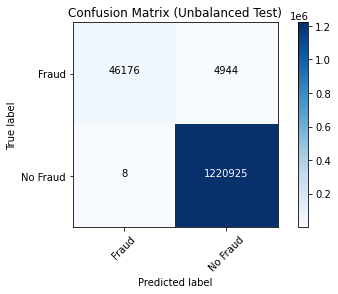

In [0]:
# Plot confusion matrix
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

# MLflow to save results
.  
1. Install and configure MLflow in this notebook
2. Log the recent model results to MLflow

### MLflow setup

In [0]:
!pip install mlflow

# Configure MLflow Experiment

# mlflow_experiment_id = 1 -- Tried this ... got "RestException: RESOURCE_DOES_NOTE_EXIST: Node 1 does not exist"
# mlflow_experiment_id = 866112   # used in demo  -- Same error


# Including MLflow
import mlflow
import mlflow.spark

import os
print("MLflow Version: %s" % mlflow.__version__)

Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.30.0)
Requirement already satisfied: cloudpickle<3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.0)
Requirement already satisfied: databricks-cli<1,>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.16.3)
Requirement already satisfied: click<9,>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (7.1.2)
Requirement already satisfied: pytz<2023 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: sqlparse<1,>=0.4.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.1)
Requirement already satisfied: entrypoints<1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: requests<3,>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.28.1)
Requirement already satisfied: numpy<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.20.1)
Requirement already satisfied: pandas<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: docker<7,>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (6.0.0)
Requirement already satisfied: importlib-metadata!=4.7.0,<6,>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.10.0)
Requirement already satisfied: protobuf<5,>=3.12.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.2)
Requirement already satisfied: prometheus-flask-exporter<1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.20.3)
Requirement already satisfied: pyyaml<7,>=5.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.4.1)
Requirement already satisfied: alembic<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.8.1)
Requirement already satisfied: gitpython<4,>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.12)
Requirement already satisfied: scipy<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.2)
Requirement already satisfied: sqlalchemy<2,>=1.4.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.42)
Requirement already satisfied: gunicorn<21 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.0.4)
Requirement already satisfied: packaging<22 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (21.3)
Requirement already satisfied: Flask<3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.1.2)
Requirement already satisfied: querystring-parser<2 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: importlib-resources in /databricks/python3/lib/python3.8/site-packages (from alembic<2->mlflow) (5.10.0)
Requirement already satisfied: Mako in /databricks/python3/lib/python3.8/site-packages (from alembic<2->mlflow) (1.1.3)
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli<1,>=0.8.7->mlflow) (0.8.7)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli<1,>=0.8.7->mlflow) (1.15.0)
Requirement already satisfied: websocket-client>=0.32.0 in /databricks/python3/lib/python3.8/site-packages (from docker<7,>=4.0.0->mlflow) (0.57.0)
Requirement already satisfied: urllib3>=1.26.0 in /databricks/python3/lib/python3.8/site-packages (from docker<7,>=4.0.0->mlflow) (1.26.12)
Requirement already satisfied: Jinja2>=2.10.1 in /databricks/python3/lib/python3.8/site-packages (from Flask<3->mlflow) (2.11.3)
Requirement already satisfied: itsdangerous>=0.24 in /databricks/python3/lib/python3.8/site-packages (from Flask<3->mlflow) (1.1.0)
Requirement already satisfied: Werkzeug>=0.15 in /databricks/python3/lib/python3.8/site-packages (from Flask<3->mlflow)

### Log results with MLflow

I ended up having to make an MLflow experiment

Experiment with ID 2011782222727920 was created.

In [0]:
mlflow_experiment_id = 2011782222727920

# Log with MLflow
with mlflow.start_run(experiment_id = mlflow_experiment_id) as run:
    # Log parameters and metrics
    mlflow.log_param("balanced", "no")
    mlflow.log_metric("PR train", pr_train)
    mlflow.log_metric("AUC train", auc_train)
    mlflow.log_metric("PR test", pr_test)
    mlflow.log_metric("AUC test", auc_test)
    
    # Log model
    mlflow.spark.log_model(cvModel, "model") # whoops this is wrong
    # What the demo did was...
    # mlflow.spark.log_model(dt_model, "model")
    
    # Log Confusion matrix
    mlflow.log_artifact("confusion-matrix.png")

# Model with Balanced Classes

Recall from the EDA section (and the confusion matrix), there is a **disproportionate number of transactions without fraud (0)** compared to fraudulent transactions (1).  
.  
This next section addresses this disparity, and prepares a new dataset that balances the presence of classes in the dataset.

In [0]:
# Reset the DataFrames for no fraud ('dfn') and fraud ('dfy') -- I guess I didn't actually do this, but the tutorial did
dfn = train.filter(train.label == 0)
dfy = train.filter(train.label == 1)

# Calculate summary metrics
N = train.count()
y = dfy.count()
p = y/N       # p = fraction of transactions that are fraudulent
print(f"\n{p:.2%} of transactions are fraudulent")

4.02% of transactions are fraudulent

In [0]:
# Creating the more balanced dataset now
train_bal = dfn.sample(False, p, seed = 92285).union(dfy)

# Print out metrics
print("\n\n")
print("Total count: %s" % N)
print("Fraud cases count: %s" % y)
print("Proportion of fraud cases: %s" % p)
print()
print("Balanced training dataset count: %s" % train_bal.count())

Total count: 5090567
Fraud cases count: 204520
Proportion of fraud cases: 0.04017627113050472

Balanced training dataset count: 400376

In [0]:
# Displaying the balanced training dataset
display(train_bal.groupBy("label").count())

label,count
0,195856
1,204520


Output can only be rendered in Databricks

# Updating the ML pipeline for balanced data

We can use some of the pipeline pieces from ealier:
1. DecisionTree classifier object -> `dt`
2. Hyperparameters -> `paramGrid`
3. `evaluatorAUC` -> this is more common for balanced datasets, so I am replacing `evaluatorPR` (precision-recall) with `evaluatorAUC` (area under the curve)
4. `StringIndexer` object -> `typeIndexer`
5. `VectorAssembler` (`va`) -> assembles a vector from column names of a DataFrame

In [0]:
# Re-run the same ML pipeline (including parameters grid)
crossval_bal = CrossValidator(
                            estimator = dt,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluatorPR,
                            numFolds = 3
                          )

pipelineCV_bal = Pipeline(stages=[typeIndexer, va, crossval_bal])

# Train the model using the pipeline, parameter grid, and BinaryClassificationEvaluator using the "train_bal" dataset
cvModel_bal = pipelineCV_bal.fit(train_bal)

## Repeating evaluation process

In [0]:
# Create the predicted outputs again
train_pred_bal = cvModel_bal.transform(train_bal)
test_pred_bal = cvModel_bal.transform(val)  # test)  - whoops ... same problem as earlier

# Evaluate the model on the balanced dataset
pr_train_bal = evaluatorPR.evaluate(train_pred_bal)
auc_train_bal = evaluatorAUC.evaluate(train_pred_bal)

# Evaluate the model on the test dataset
pr_test_bal = evaluatorPR.evaluate(test_pred_bal)
auc_test_bal = evaluatorAUC.evaluate(test_pred_bal)


In [0]:
# Printing out the results
2
print("----- Balanced Training Data ------")
print(f"Precision-Recall (PR) on BALANCED TRAIN data: {pr_train_bal:.3f}")
print(f"Area under the Curve (AUC) on BALANCED TRAIN data: {auc_train_bal:.3f}")
print("----- Test -------")
print(f"Precision-Recall (PR) on TEST data: {pr_test_bal:.3f}")
print(f"Area under the Curve (AUC) on TEST data: {auc_test_bal:.3f}")

----- Balanced Training Data ------
Precision-Recall (PR) on BALANCED TRAIN data: 0.999
Area under the Curve (AUC) on BALANCED TRAIN data: 0.999
----- Test -------
Precision-Recall (PR) on TEST data: 0.998
Area under the Curve (AUC) on TEST data: 0.999

### Analysis: Improvement

Wow... that is actually a pretty significant improvement.
.  
All PR and AUC metrics are nearly 1 compared to values around 0.95 from the first attempt.
.  
I am actually quite surprised by the improved performance. This is definitely evidence that it is a good idea to consider balancing financial data. Or, it is evidence that the balance of data should certainly be noted and visualized for consideration.

## New Confusion Matrix

In [0]:
# Create a temporary view for test predictions
test_pred_bal.createOrReplaceTempView("test_pred_bal") # this allows us to access the data as a table

# Create test predictions confusion matrix - THIS IS THE SAME COMPLICATED QUERY FROM THE PREVIOUS CONFUSION MATRIX
test_pred_bal_cmdf = spark.sql("select a.label, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select label, prediction, count(1) as count from test_pred_bal group by label, prediction) b on b.label = a.label and b.prediction = a.prediction order by a.label desc, a.prediction desc")

# View confusion matrix
display(test_pred_bal_cmdf)

label,prediction,count
1,1,51004
1,0,116
0,1,50
0,0,1220883


^^^ much lower rate of mistakes in the data above!

In [0]:
# Convert to pandas
cm_bal_pdf = test_pred_bal_cmdf.toPandas()

# Create 1d numpy array of confusion matrix values
cm_bal_1d = cm_bal_pdf.iloc[:,2].to_numpy()

# Create 2d numpy array of confusion matrix values
cm_bal = np.reshape(cm_bal_1d, (-1,2))

print(cm_bal)

[[ 51004 116]
 [ 50 1220883]]

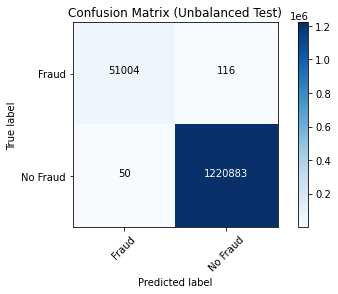

In [0]:
# Plot confusion matrix
plot_confusion_matrix(cm_bal, "Confusion Matrix (Unbalanced Test)")

# View Decision Tree Models

Next, I am going to visually compare the differences between the **unbalanced** and **balanced** decision tree models (based on the `train` and `train_bal` datasets respectively).

## Setting up a Function to Extract Feature Importance

I don't really understand what this function is doing, but I'm not going to worry about it for now.
.  
Seems like it might select/extract features based on importances provided as input.

In [0]:
# Extract Feature Importance
#  Attribution: Feature Selection Using Feature Importance Score - Creating a PySpark Estimator

# Reference:
#               https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

# Viewing decision tree produced with *unbalanced* data
.  
NOTE: CrossValidator objects (used for training and hyperparameter tuning) do not offer the option to extract and display the DecisionTree classifier

In [0]:
dt_unbalanced = pipeline.fit(train)
display(dt_unbalanced.stages[-1])

treeNode
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":56716.69,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":1,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,1.0,2.0,4.0],""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":145.585,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":9.545,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":740667.12,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":8,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


In [0]:
# Extract Feature Importance for the original unbalanced DecisionTree model (dt_unbalanced)

ExtractFeatureImp(dt_unbalanced.stages[-1].featureImportances, train_pred, "features").head(10)

Out[33]:

,idx,name,vals,score
2,3,newbalanceOrig,NaN,0.905253
1,2,oldbalanceOrg,NaN,0.088330
4,5,newbalanceDest,NaN,0.005784
0,1,amount,NaN,0.000319
5,0,typeIndexed,"[CASH_OUT, PAYMENT, CASH_IN, TRANSFER, DEBIT]",0.000315
3,4,oldbalanceDest,NaN,0.000000


## Viewing decision tree produced by *balanced* data

In [0]:
dt_balanced = pipeline.fit(train_bal)
display(dt_balanced.stages[-1])

treeNode
"{""index"":19,""featureType"":""continuous"",""prediction"":null,""threshold"":58579.5,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":42261.5,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":1,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,2.0,3.0,4.0],""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":367.01,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":13,""featureType"":""continuous"",""prediction"":null,""threshold"":8.44,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":367.01,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":7,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,2.0],""feature"":0,""overflow"":false}"


In [0]:
# Extract Feature Importance for the balanced DecisionTree model (dt_balanced)
ExtractFeatureImp(dt_balanced.stages[-1].featureImportances, train_pred_bal, "features").head(10)

Out[36]:

,idx,name,vals,score
1,2,oldbalanceOrg,NaN,0.531901
2,3,newbalanceOrig,NaN,0.454900
4,5,newbalanceDest,NaN,0.009597
0,1,amount,NaN,0.002739
5,0,typeIndexed,"[CASH_OUT, TRANSFER, PAYMENT, CASH_IN, DEBIT]",0.000863
3,4,oldbalanceDest,NaN,0.000000


# Comparing confusion matrices now

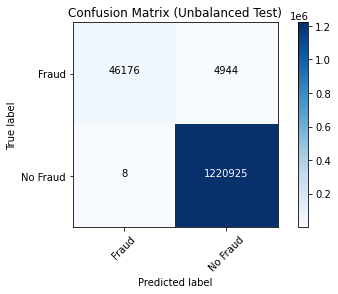

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

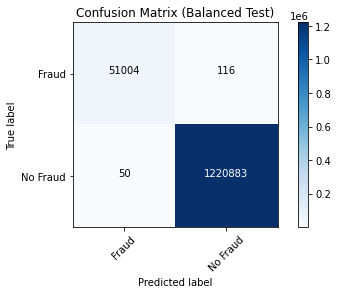

In [0]:
plot_confusion_matrix(cm_bal, "Confusion Matrix (Balanced Test)")

# Saving "balanced" results with MLflow

In [0]:
# Including MLflow
import mlflow
import mlflow.spark

import os

mlflow_experiment_id = 2011782222727920

with mlflow.start_run(experiment_id = mlflow_experiment_id) as run:
    # Log Parameters and metrics
    mlflow.log_param("balanced", "yest")
    mlflow.log_metric("PR train", pr_train_bal)
    mlflow.log_metric("AUC train", auc_train_bal)
    mlflow.log_metric("PR test", pr_test_bal)
    mlflow.log_metric("AUC test", auc_test_bal)
    
    # Log model
    mlflow.spark.log_model(dt_balanced, "model")
    mlflow.spark.log_model(cvModel_bal, "trained_model")
    
    # Log Confusion matrix
    mlflow.log_artifact("confusion-matrix.png")

# Observation

Making a nice little table to view some of the results.  
The results can also be viewed in other visualization formats in the MLflow experiment.

| Metric/dataset | Unbalanced | Balanced |
| -------------- | ---------- | -------- |
| PR train | 0.954 | 0.999 |
| AUC train | 0.952 | 0.999 |
| PR test | 0.953 | 0.998 |
| AUC test | 0.952 | 0.999 |

.  
The size of the balanced training set might be smaller (and easier to "memorize"), but the test results are obtained on the exact same data. Thus, the balanced training dataset seems to have produced a DT classifier that is much better according the metric chosen.

# THE END